# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Import used packages
import pickle
import pandas as pd
import numpy as np
import cv2
import itertools
import textwrap
from sklearn.utils import shuffle
import sklearn.preprocessing
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

In [2]:
# Load pickled data

data_directory  = "traffic-signs-data/"
training_file   = data_directory + "train.p"
validation_file = data_directory + "valid.p"
testing_file    = data_directory + "test.p"
test_own_file   = data_directory + "test_own.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
with open(test_own_file, mode='rb') as f:
    test_own = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']
X_test_own, y_test_own = test_own['features'], test_own['labels']
X_test_own_raw = X_test_own.copy()

class_names = pd.read_csv('signnames.csv')["SignName"]

assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test)  == len(y_test))
assert(len(X_test_own)  == len(y_test_own))

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
# Number of training examples
n_train = X_train.shape[0]

# Number of validation examples
n_validation = X_valid.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# Number of own testing examples.
n_test_own = X_test_own.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# How many unique classes/labels there are in the dataset.
n_classes = len(set(np.concatenate([y_train, y_test])))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Number of own testing examples =", n_test_own)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Number of own testing examples = 50
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

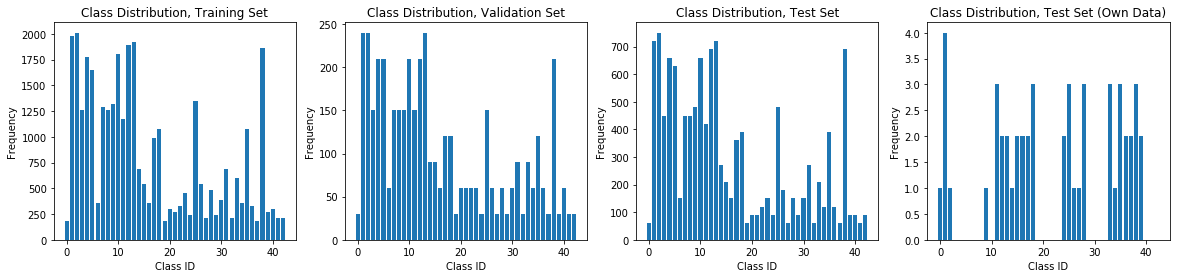

Visualization of 3 sample images for each class from the training set


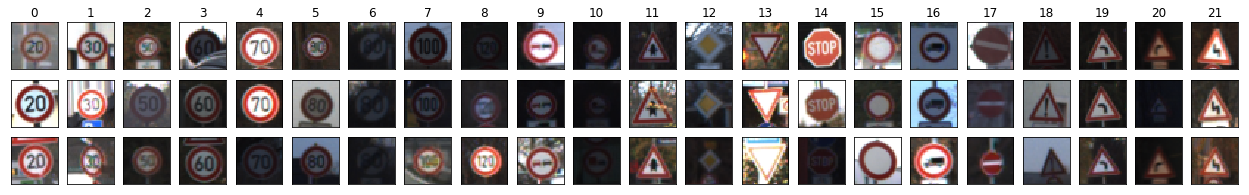

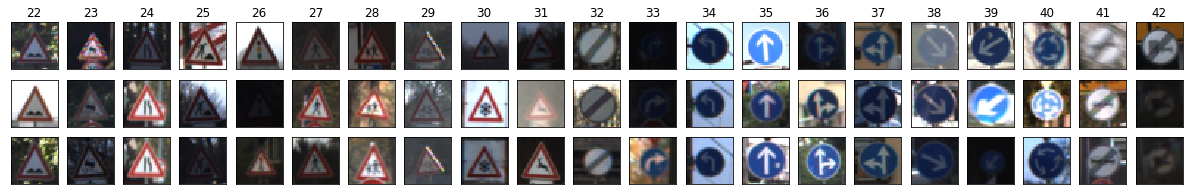

In [4]:
### Data exploration visualization code goes here.

# Plot class distributions for training, validation and test set
bin_boundaries = np.arange(-0.5, n_classes)
f, ax = plt.subplots(1, 4, figsize=[20,4])
n_per_class, bins, patches = ax[0].hist(y_train, bins=bin_boundaries, rwidth=0.8)
ax[1].hist(y_valid, bins=bin_boundaries, rwidth=0.8)
ax[2].hist(y_test, bins=bin_boundaries, rwidth=0.8)
ax[3].hist(y_test_own, bins=bin_boundaries, rwidth=0.8)
ax[0].set_title('Class Distribution, Training Set')
ax[1].set_title('Class Distribution, Validation Set')
ax[2].set_title('Class Distribution, Test Set')
ax[3].set_title('Class Distribution, Test Set (Own Data)')
for i in range(4):
    ax[i].set_xlabel("Class ID")
    ax[i].set_ylabel("Frequency")
plt.show()

# Visualize three sample images for each class
print("Visualization of 3 sample images for each class from the training set")
sorted_train_indices = np.argsort(y_train)
n_examples = 3
split = n_classes//2
split2 = n_classes - split
f1, ax1 = plt.subplots(n_examples, split2, figsize=[split2,n_examples])
f2, ax2 = plt.subplots(n_examples, split, figsize=[split,n_examples])
ax = [ax1, ax2]
cnt = 0
for i in range(len(n_per_class)):
    for j in range(n_examples):
        index = sorted_train_indices[np.random.randint(cnt, cnt + n_per_class[i])]
        image = X_train[index].squeeze()
        curr_ax = ax[i//split2][j][i%(split+1)]
        curr_ax.imshow(image)
        curr_ax.xaxis.set_visible(False)
        curr_ax.yaxis.set_visible(False)
    ax[i//split2][0][i%(split+1)].set_title(i)
    cnt += n_per_class[i]

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [5]:
# Utility functions for data augmentation

def scale_image(img, factor=1.):
    """
    Scales the image by a given factor.
    """
    if factor > 1.:
        interp = cv2.INTER_CUBIC
    elif factor < 1.:
        interp = cv2.INTER_AREA
    else:
        return img
    res = cv2.resize(img, None, fx=factor, fy=factor, interpolation = interp)
    return res

def fit_image_to_size(img, size=32):
    """
    Resizes images to given size in both dimensions.
    Bigger images are cropped, smaller images are padded with zeros.
    """
    assert img.shape[0] == img.shape[1], "'fit_image_to_size' only works with square images"
    
    if img.shape[0] > size:
        diff_half = (img.shape[0] - size) // 2
        res = img[diff_half:diff_half+size, diff_half:diff_half+size ,:]
    elif img.shape[0] < size:
        diff = (size - img.shape[0])
        diff_half = diff // 2
        diff_half2 = diff - diff_half
        res = cv2.copyMakeBorder(img,diff_half,diff_half2,diff_half,diff_half2,cv2.BORDER_CONSTANT)
    else:
        return img
    return res

def shift_image(img, xshift=0, yshift=0, size=32):
    """
    Shifts the image in x- and y-directions (corresponding to width and height).
    """
    if xshift == 0 and yshift == 0:
        return img
    M = np.float32([[1,0,xshift],[0,1,yshift]])
    res = cv2.warpAffine(img, M, (size,size))
    return res

def rotate_image(img, degrees=0, size=32):
    """
    Rotate the image by a given angle.
    """
    if degrees == 0:
        return img
    M = cv2.getRotationMatrix2D((size/2,size/2), degrees, 1)
    res = cv2.warpAffine(img, M, (size,size))
    return res

def create_augmented_sample(img, f, xs, ys, r):
    """
    Apply all of the above to create an augmented image.
    f, xs, ys, r are the parameters of the previous functions.
    """
    res = scale_image(img, factor=f)
    if f < 1.:
        res = fit_image_to_size(res)
    res = rotate_image(res, r)
    res = shift_image(res, xs, ys)
    if f > 1.:
        res = fit_image_to_size(res)
    return res

In [6]:
# Data augmentation configurations

scalings = [0.89, 1., 1.11]
xshifts = [-2, 0 ,2]
yshifts = [-2, 0 ,2]
rotations = [-15, -10, -5, 0, 5, 10, 15]

# Create all combinations of possible (discrete) augmentation configurations
aug_confs = list(itertools.product(scalings, xshifts, yshifts, rotations))

# Remove configuration that would not create a new data sample, i.e. augmentation function would become identity function
aug_confs.remove((1.,0,0,0))

In [7]:
# Number of data augmentations per class

# Target 2000 samples for each class
target_samples_per_class = 2000

# Calculate how many augmentations need to be done per class
base_augs = target_samples_per_class // n_per_class - 1
added_augs = target_samples_per_class % n_per_class
valid_augs = base_augs >= 0
base_augs *= valid_augs
added_augs *= valid_augs

total_augs = int(sum(valid_augs * (target_samples_per_class - n_per_class)))

Examples of augmented data (original on top, generated sample on bottom)


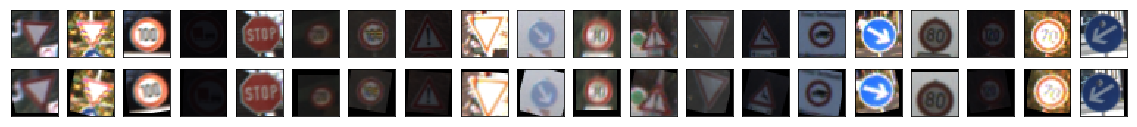

In [8]:
print("Examples of augmented data (original on top, generated sample on bottom)")
n_aug_plots = 20
f, ax = plt.subplots(2, n_aug_plots, figsize=[n_aug_plots,2])
plot_cnt = 0

# Perform data augmentation
X_train, y_train = shuffle(X_train, y_train)
augmented_X_samples = np.zeros((total_augs, image_shape[0], image_shape[1], image_shape[2]), dtype='uint8')
augmented_y_samples = np.zeros((total_augs,))
aug_cnt = 0
for i in range(len(X_train)):
    y = y_train[i]
    n_augs = int(base_augs[y])
    if added_augs[y] > 0:
        added_augs[y] -= 1
        n_augs += 1
    aug_confs = shuffle(aug_confs)
    for j in range(n_augs):
        augmented_X_samples[aug_cnt] = create_augmented_sample(X_train[i], *aug_confs[j])
        augmented_y_samples[aug_cnt] = y
        aug_cnt += 1
    
    # Plot some augmentations
    if n_augs > 0 and plot_cnt < n_aug_plots:
        curr_ax = ax[0][plot_cnt]
        curr_ax.imshow(X_train[i])
        curr_ax.xaxis.set_visible(False)
        curr_ax.yaxis.set_visible(False)

        curr_ax = ax[1][plot_cnt]
        curr_ax.imshow(augmented_X_samples[aug_cnt-1])
        curr_ax.xaxis.set_visible(False)
        curr_ax.yaxis.set_visible(False)

        plot_cnt += 1

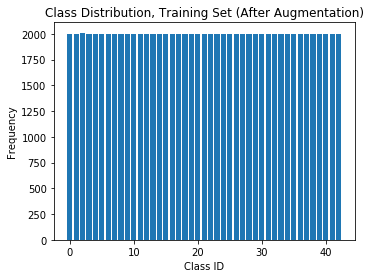

In [9]:
# Append augmented data to training set

X_train = np.concatenate([X_train, augmented_X_samples], axis=0)
y_train = np.concatenate([y_train, augmented_y_samples], axis=0)
n_train = X_train.shape[0]

# Plot new training set class distribution
plt.figure(figsize=(5.4,4))
plt.hist(y_train, bins=bin_boundaries, rwidth=0.8)
plt.title('Class Distribution, Training Set (After Augmentation)')
plt.xlabel("Class ID")
plt.ylabel("Frequency")
plt.show()

Examples of grayscaled + histogram equalized data (original on top, preprocessed sample on bottom)


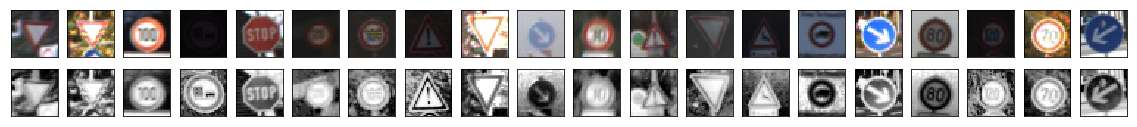

In [10]:
# Data normalization

def normalize_data(X, add_gray=True, plot_examples=False):
    """
    Normalizes the data on a per image basis.
    Each pixel's value is substracted by the mean and divided by the standard deviation of the image.
    If 'add_gray' is set to True then one extra channel is added to the data which contains 
    the grayscaled image preprocessed with histogram equalization.
    """
    n = X.shape[0]
    width = X.shape[1]
    height = X.shape[2]
    channels = X.shape[3]
    if add_gray:
        gray_images = np.zeros((n, width, height, 1), dtype='uint8')
        for i in range(n):
            gray_images[i, :, :, 0] = cv2.cvtColor(X[i], cv2.COLOR_RGB2GRAY)
            gray_images[i, :, :, 0] = cv2.equalizeHist(gray_images[i, :, :, 0])

        X = np.concatenate([X, gray_images], axis=3)
        channels += 1
        
        # Plot some examples
        if plot_examples:
            print("Examples of grayscaled + histogram equalized data (original on top, preprocessed sample on bottom)")
            f, ax = plt.subplots(2, plot_examples, figsize=[plot_examples,2])
            for i in range(plot_examples):
                curr_ax = ax[0][i]
                curr_ax.imshow(X[i,:,:,:3])
                curr_ax.xaxis.set_visible(False)
                curr_ax.yaxis.set_visible(False)

                curr_ax = ax[1][i]
                curr_ax.imshow(X[i,:,:,-1], cmap="gray")
                curr_ax.xaxis.set_visible(False)
                curr_ax.yaxis.set_visible(False)
            plt.show()

    tmp = X.reshape((n, width * height, channels))
    norm = X - np.mean(tmp, axis=1).reshape((n, 1, 1, channels))
    X = norm / np.std(tmp, axis=1).reshape((n, 1, 1, channels))

    X = X.astype('float32')
    
    return X

X_train = normalize_data(X_train, plot_examples=20)
X_valid = normalize_data(X_valid)
X_test = normalize_data(X_test)
X_test_own = normalize_data(X_test_own)

### Model Architecture

In [11]:
"""
Hyperparameters of deep learning
"""

EPOCHS = 30
BATCH_SIZE = 128

# Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
mu = 0
sigma = 0.1

dropout_param = 0.8

rate = 0.001

num_channels = X_train.shape[3]

In [12]:
conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, num_channels, 6), mean = mu, stddev = sigma))
conv1_b = tf.Variable(tf.zeros(6))
conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
conv2_b = tf.Variable(tf.zeros(16))
fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
fc1_b = tf.Variable(tf.zeros(120))
fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
fc2_b  = tf.Variable(tf.zeros(84))
fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
fc3_b  = tf.Variable(tf.zeros(n_classes))


def LeNet(x, dropout):        
    # Layer 1: Convolutional. Input = 32x32x4. Output = 28x28x6.
    conv1_orig = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    conv1 = tf.nn.relu(conv1_orig)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_orig = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    conv2 = tf.nn.relu(conv2_orig)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    fc1    = tf.nn.relu(fc1)
    fc1    = tf.nn.dropout(fc1, dropout)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    fc2    = tf.nn.relu(fc2)
    fc2    = tf.nn.dropout(fc2, dropout)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits, conv1_orig, conv2_orig

In [13]:
x = tf.placeholder(tf.float32, (None, 32, 32, num_channels))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
keep_prob = tf.placeholder(tf.float32)

In [14]:
logits, conv1, conv2 = LeNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

top5 = tf.nn.top_k(tf.nn.softmax(logits), k=5)

In [15]:
prediction_labels = tf.argmax(logits, 1)
correct_prediction = tf.equal(prediction_labels, tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    all_pred_labels = []
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy, pred_labels = sess.run([accuracy_operation, prediction_labels], feed_dict={x: batch_x, y: batch_y, keep_prob:1.})
        total_accuracy += (accuracy * len(batch_x))
        all_pred_labels.extend(pred_labels)
    return total_accuracy / num_examples, all_pred_labels

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [16]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        total_accuracy = 0
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            _, train_accuracy = sess.run([training_operation, accuracy_operation], feed_dict={x: batch_x, y: batch_y, keep_prob: dropout_param})
            total_accuracy += (train_accuracy * len(batch_x))
            
        validation_accuracy, pred_labels = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f} ({}% Dropout)".format(total_accuracy / len(X_train), int(100-dropout_param*100)))
        print("Validation Accuracy = {:.3f} (0% Dropout)".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Training Accuracy = 0.548 (20% Dropout)
Validation Accuracy = 0.878 (0% Dropout)

EPOCH 2 ...
Training Accuracy = 0.825 (20% Dropout)
Validation Accuracy = 0.935 (0% Dropout)

EPOCH 3 ...
Training Accuracy = 0.887 (20% Dropout)
Validation Accuracy = 0.946 (0% Dropout)

EPOCH 4 ...
Training Accuracy = 0.915 (20% Dropout)
Validation Accuracy = 0.960 (0% Dropout)

EPOCH 5 ...
Training Accuracy = 0.933 (20% Dropout)
Validation Accuracy = 0.966 (0% Dropout)

EPOCH 6 ...
Training Accuracy = 0.942 (20% Dropout)
Validation Accuracy = 0.969 (0% Dropout)

EPOCH 7 ...
Training Accuracy = 0.950 (20% Dropout)
Validation Accuracy = 0.971 (0% Dropout)

EPOCH 8 ...
Training Accuracy = 0.957 (20% Dropout)
Validation Accuracy = 0.973 (0% Dropout)

EPOCH 9 ...
Training Accuracy = 0.960 (20% Dropout)
Validation Accuracy = 0.971 (0% Dropout)

EPOCH 10 ...
Training Accuracy = 0.964 (20% Dropout)
Validation Accuracy = 0.980 (0% Dropout)

EPOCH 11 ...
Training Accuracy = 0.966 (20% Dr

In [17]:
print("Precision-Recall per class for the validation set:")
print(classification_report(y_valid, pred_labels, target_names=class_names))

Precision-Recall per class for the validation set:
                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       1.00      1.00      1.00        30
                              Speed limit (30km/h)       0.99      0.97      0.98       240
                              Speed limit (50km/h)       1.00      0.97      0.99       240
                              Speed limit (60km/h)       0.99      0.96      0.97       150
                              Speed limit (70km/h)       0.97      1.00      0.98       210
                              Speed limit (80km/h)       0.97      0.98      0.97       210
                       End of speed limit (80km/h)       1.00      1.00      1.00        60
                             Speed limit (100km/h)       0.99      1.00      1.00       150
                             Speed limit (120km/h)       0.97      0.98      0.98       150
                            

In [18]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy, pred_labels = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

print("Precision-Recall per class for the test set:")
print(classification_report(y_test, pred_labels, target_names=class_names))

Test Accuracy = 0.957
Precision-Recall per class for the test set:
                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       0.86      0.73      0.79        60
                              Speed limit (30km/h)       0.97      0.97      0.97       720
                              Speed limit (50km/h)       0.97      0.98      0.98       750
                              Speed limit (60km/h)       0.94      0.92      0.93       450
                              Speed limit (70km/h)       0.98      0.96      0.97       660
                              Speed limit (80km/h)       0.92      0.95      0.93       630
                       End of speed limit (80km/h)       1.00      0.93      0.96       150
                             Speed limit (100km/h)       0.96      0.95      0.95       450
                             Speed limit (120km/h)       0.95      0.94      0.95       450
            

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [19]:
print("For this data, I went outside in my neighborhood and took pictures of road signs. From all the gathered pictures, I converted a total of 50 to the size of 32x32 to evaluate with the trained network.")

For this data, I went outside in my neighborhood and took pictures of road signs. From all the gathered pictures, I converted a total of 50 to the size of 32x32 to evaluate with the trained network.


In [20]:
### Loading the data set is done together with loading the other data sets in the first cell
### I scaled the images and pickled them before, outside this notebook

### Predict the Sign Type for Each Image

In [21]:
### See below for class predictions

In [22]:
def evaluate_predictions(X_data, y_data):
    num_examples = len(X_data)
    predictions = []
    values = []
    indices = []
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        pred, t5 = sess.run([correct_prediction, top5], feed_dict={x: batch_x, y: batch_y, keep_prob:1.})
        predictions.extend(pred)
        values.extend(t5.values)
        indices.extend(t5.indices)
    return predictions, np.array(values), np.array(indices)

In [23]:
X_eval, y_eval = X_test_own, y_test_own

with tf.Session() as sess:
    # Restore variables from disk.
    saver.restore(sess, './lenet')

    test_accuracy, pred_labels = evaluate(X_eval, y_eval)
    predictions, t5_values, t5_indices = evaluate_predictions(X_eval, y_eval)

### Analyze Performance

In [24]:
print("Test Accuracy (Own Data) = {:.3f}".format(test_accuracy))
print("Precision-Recall per class for the own test set:")
print(classification_report(y_test_own, pred_labels, labels=range(n_classes), target_names=class_names))

Test Accuracy (Own Data) = 0.960
Precision-Recall per class for the own test set:
                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       0.50      1.00      0.67         1
                              Speed limit (30km/h)       1.00      0.50      0.67         4
                              Speed limit (50km/h)       1.00      1.00      1.00         1
                              Speed limit (60km/h)       0.00      0.00      0.00         0
                              Speed limit (70km/h)       0.00      0.00      0.00         0
                              Speed limit (80km/h)       0.00      0.00      0.00         0
                       End of speed limit (80km/h)       0.00      0.00      0.00         0
                             Speed limit (100km/h)       0.00      0.00      0.00         0
                             Speed limit (120km/h)       0.00      0.00      0.00        

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

Visualization of gathered data, class predictions and top 5 softmax values. Class at the very top is final prediction of the network. The correct class is highlighted in green if within top 5.


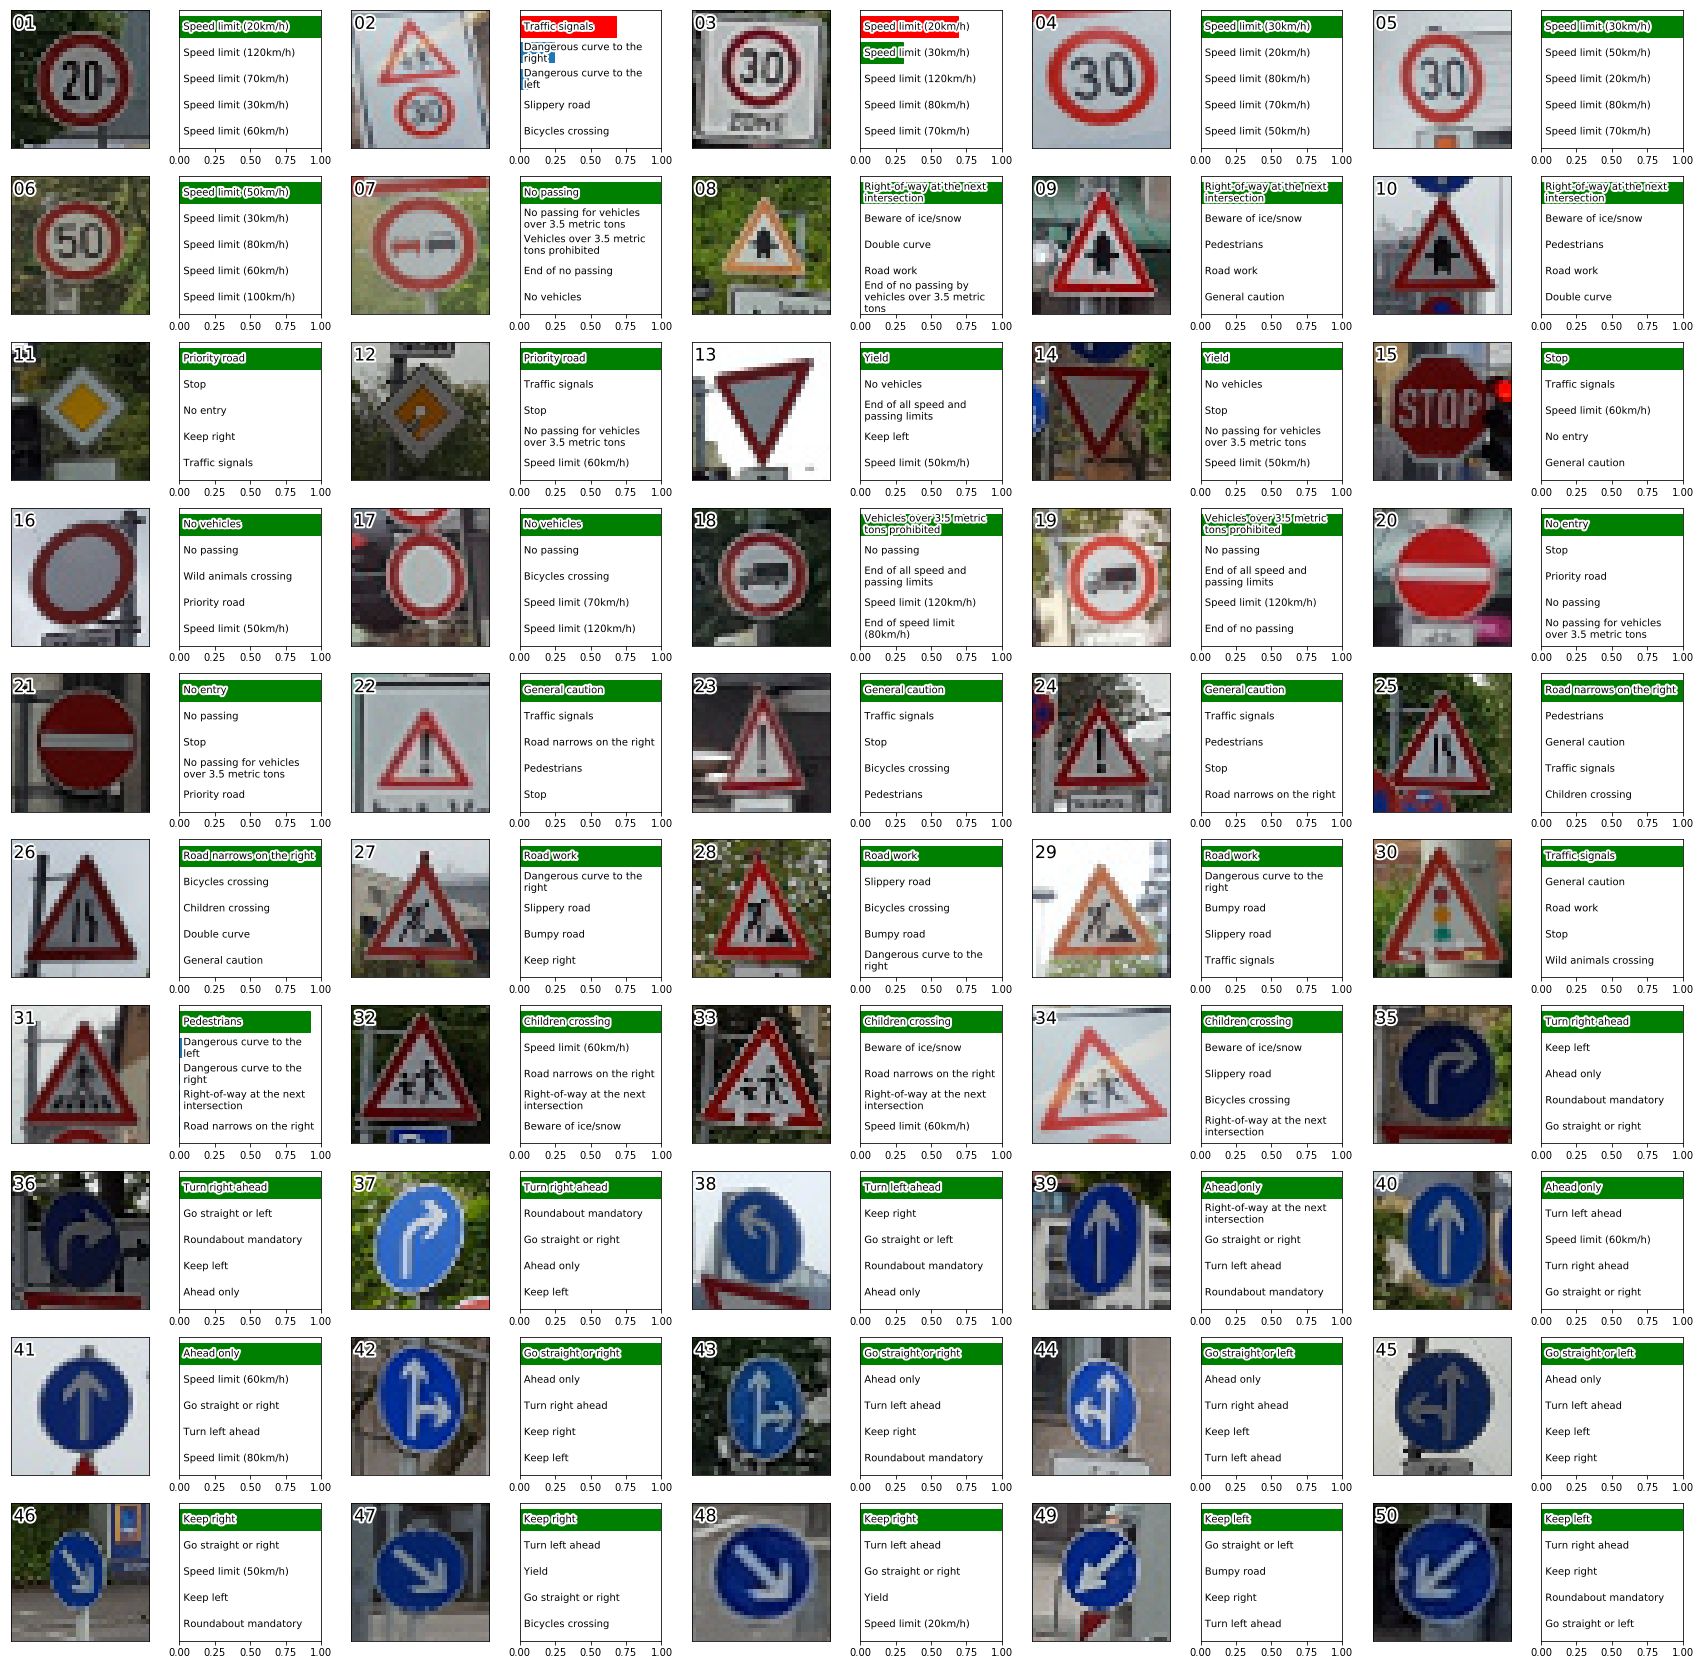

In [25]:
print("Visualization of gathered data, class predictions and top 5 softmax values. Class at the very top is final prediction of the network. The correct class is highlighted in green if within top 5.")

f, ax = plt.subplots(10, 10, figsize=[30,30])
for i in range(n_test_own):
    curr_ax = ax[i//5][(i*2)%10]
    curr_ax.imshow(X_test_own_raw[i,:,:,:3])
    txt = curr_ax.text(0.1, 0.9, str(i+1).zfill(2), size="xx-large", horizontalalignment='center', verticalalignment='center', transform=curr_ax.transAxes)
    txt.set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])
    curr_ax.xaxis.set_visible(False)
    curr_ax.yaxis.set_visible(False)

    curr_ax = ax[i//5][(i*2+1)%10]
    barlist = curr_ax.barh(np.arange(5), t5_values[i][::-1])
    if predictions[i]:
        barlist[-1].set_color('g')
    else:
        barlist[-1].set_color('r')
        for j in range(len(barlist)):
            if y_test_own[i] == t5_indices[i][-1-j]:
                barlist[j].set_color('g')
                break
    for j in range(len(barlist)):
        bar = barlist[j]
        p = class_names[t5_indices[i][-1-j]]
        p = textwrap.fill(p, 25)

        yloc = bar.get_y() + (bar.get_height() / 2.0)
        txt = curr_ax.text(0.03, yloc, p, horizontalalignment='left', verticalalignment='center', wrap=True)
        txt.set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])
                
    curr_ax.yaxis.set_visible(False)
    curr_ax.set_xlim(0,1)
    
plt.show()

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [26]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
    plt.show()
    return activation

In [27]:
"""
Author: Daeyun Shin
Taken from: https://github.com/tensorflow/tensorflow/issues/2169#issuecomment-220866192
"""
def unpool(value, name='unpool'):
    """N-dimensional version of the unpooling operation from
    https://www.robots.ox.ac.uk/~vgg/rg/papers/Dosovitskiy_Learning_to_Generate_2015_CVPR_paper.pdf

    :param value: A Tensor of shape [b, d0, d1, ..., dn, ch]
    :return: A Tensor of shape [b, 2*d0, 2*d1, ..., 2*dn, ch]
    """
    with tf.name_scope(name) as scope:
        sh = value.get_shape().as_list()
        dim = len(sh[1:-1])
        out = (tf.reshape(value, [-1] + sh[-dim:]))
        for i in range(dim, 0, -1):
            #out = tf.concat([out, out], i)
            out = tf.concat(i, [out, out])
        out_size = [-1] + [s * 2 for s in sh[1:-1]] + [sh[-1]]
        out = tf.reshape(out, out_size, name=scope)
    return out

def project_to_input(activation_input, deconv_operation, activation_placeholder, plt_num=1):
    plt.figure(plt_num, figsize=(15,15))
    for i in range(activation_input.shape[3]):
        plt.subplot(6,8, i+1)
        plt.title('AreaOrigin ' + str(i))
        act_i = activation_input.copy()
        act_i[:,:,:,:i] = 0
        act_i[:,:,:,i+1:] = 0
        reconstructed_i = sess.run(deconv_operation, feed_dict={activation_placeholder: act_i})
        plt.imshow(np.max(reconstructed_i, axis=3)[0], cmap="gray")
    plt.show()

In [28]:
featuresConv1 = tf.placeholder("float",[1,28,28,6])
unConv1_act1 = tf.nn.conv2d_transpose(featuresConv1, conv1_W, output_shape=[1,32,32,num_channels] , strides=[1,1,1,1], padding="VALID")

featuresConv2 = tf.placeholder("float",[1,10,10,16])
unConv2 = tf.nn.conv2d_transpose(featuresConv2, conv2_W, output_shape=[1,14,14,6] , strides=[1,1,1,1], padding="VALID")
unPool = unpool(unConv2)
unReLu = tf.nn.relu(unPool)
unConv1_act2 = tf.nn.conv2d_transpose(unReLu, conv1_W, output_shape=[1,32,32,num_channels] , strides=[1,1,1,1], padding="VALID")

Original Image


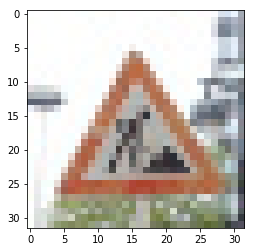

Feature activations of 1st convolutional layer


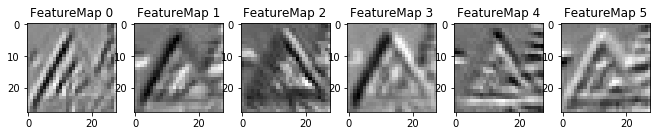

Feature activation of 2nd convolutional layer


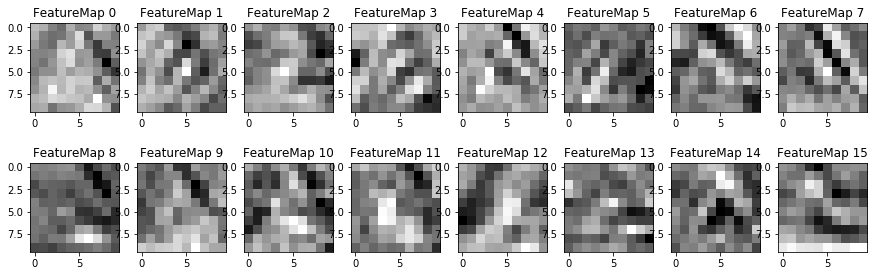

Area of original image corresponding to feature activations of 1st convolutional layer


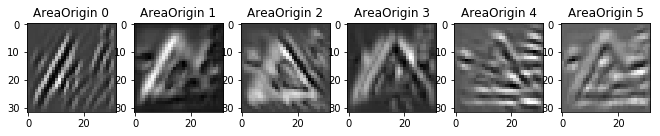

Area of original image corresponding to feature activations of 2nd convolutional layer


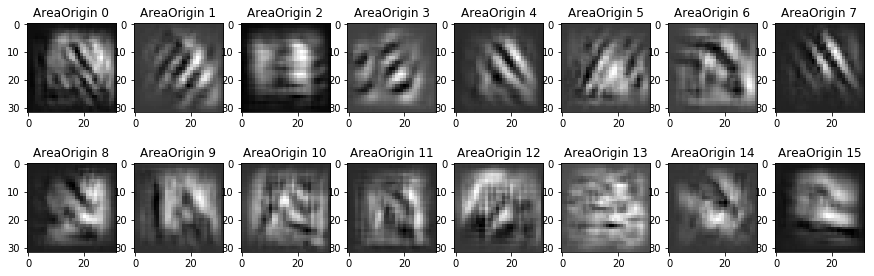

In [29]:
img_id = np.random.randint(n_test_own)
x_input = X_test_own[img_id]

print("Original Image")
plt.imshow(X_test_own_raw[img_id])
plt.show()

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    print("Feature activations of 1st convolutional layer")
    act1 = outputFeatureMap(x_input.reshape(1,32,32,num_channels), conv1)
    print("Feature activation of 2nd convolutional layer")
    act2 = outputFeatureMap(x_input.reshape(1,32,32,num_channels), conv2, plt_num=2)
    
    print("Area of original image corresponding to feature activations of 1st convolutional layer")
    project_to_input(act1, unConv1_act1, featuresConv1, plt_num=3)
    print("Area of original image corresponding to feature activations of 2nd convolutional layer")
    project_to_input(act2, unConv1_act2, featuresConv2, plt_num=4)